In [8]:
import sys
import os
sys.path.append("../")  # look one directory up for qca modules, TODO: make a package
from copy import copy as copy
from qca import QCA
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rcParams
import matplotlib.pyplot as plt
import measures as ms
from matrix import ops
import numpy as np
from scipy.optimize import curve_fit
from figures import colors, names, lettering, exp_fit, powerlaw_fit, page_fit

%matplotlib inline

from matplotlib import rc
fontstyle = {
    "pdf.fonttype": 42,
    "text.usetex": True,
    "text.latex.preamble":r"\usepackage{amsfonts}",
    "font.family": "serif",
    "axes.labelsize": 9,
    'axes.titlesize': 9,
    "font.size": 9,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
}
plt.rcParams.update(fontstyle)
rc('mathtext', default='regular')
rc("text", usetex=True)


der = r"/home/lhillber/documents/research/cellular_automata/qeca/qca/data/"

In [59]:
params_template = dict(
              L=19,
              T=1000.0,
              dt=1.0,
              R=6,
              r=1,
              V="H",
              BC="1-00",
              IC="c3_f1",
              E=0.0,
              N=1,
              totalistic=False,
              hamiltonian=False,
              trotter=True,
              symmetric=False)

Hparams_template = dict(
              L=19,
              T=1000.0,
              dt=0.1,
              R=4,
              r=2,
              V="X",
              BC="1-0000",
              IC="c3_f0-2",
              E=0.0,
              N=1,
              totalistic=True,
              hamiltonian=True,
              trotter=True,
              symmetric=True)

In [60]:
Ls = list(np.arange(6, 20))
Rs = [6, 1, 14, 4, 26]
ICs = [("c3_f1", "c3_f0-2"), "R123"]
Qs = np.zeros((len(ICs), len(Rs), len(Ls)), dtype="object")
     
for ICi, IC in enumerate(ICs):
    for Ri, R in enumerate(Rs):
        for Li, L in enumerate(Ls):
            if R in (4, 26):
                params = copy(Hparams_template)
                ICj = 1
                
            else:
                params = copy(params_template)
                ICj = 0
            if ICi == 0:
                IC = ICs[ICi][ICj]
            params["R"] = R
            params["L"] = L
            params["IC"] = IC
            Q = QCA(params, der=der)
            assert np.any([k in Q.available_tasks for k in 
                      ("bisect", "bipart",  "ebisectdata", "ebipartdata")])
            Qs[ICi, Ri, Li] = Q

plot saved to  figures/figure2_V14.pdf


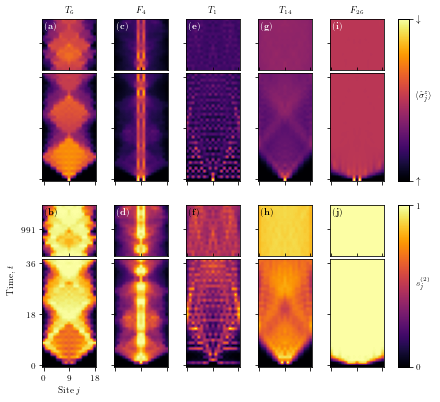

In [70]:
from figures import names, colors, letters
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colorbar import Colorbar

# figure rows and their color map
measures = ["exp_Z", "s_2"]
cmaps = ["inferno_r", "inferno"]

# setup plots
plot_fname = "figures/figure2_V14.pdf"
fig = plt.figure(figsize=(3.375 * 2, 6.4))

# QCA specifications
plot_Rs = [6, 4, 1, 14, 26]

# panel labels and colors
letts1 = [
    letters[0],
    letters[2],
    letters[4],
    letters[6],
    letters[8],
]
letts2 = [
    letters[1],
    letters[3],
    letters[5],
    letters[7],
    letters[9],
]
clett1 = ["w", "w", "w", "w", "w"]
clett2 = ["k", "w", "k", "k", "k"]
letts = [letts1, letts2]
cletts = [clett1, clett2]

Li=-1

# loop for plot rows
for row, (meas, letti, cli) in enumerate(zip(measures, letts, cletts)):
    # image grid for each row of plots
    grid = ImageGrid(
        fig,
        int("21" + str(1 + row)),
        nrows_ncols=(2, len(plot_Rs)),
        direction="row",
        axes_pad=[0.25, 0.04],
        cbar_mode="single",
        cbar_location="right",
        cbar_size="10%",
        cbar_pad=0.2,
    )

    # loop for plot columns
    for col, (R, lett, cl) in enumerate(zip(plot_Rs, letti, cli)):
        Ri = list(Rs).index(R)
        Q = Qs[0, Ri, Li]
        T1 = (Q.L - 1) * 2 + 2  # plot ylim
        T2 = (Q.L - 1) * 1  # plot ylim

        m = Q.get_measure(meas)[::int(1/Q.dt)]
        
        if meas[0] == "e":
            ticks = [-1, 1]
            ticklabels = [
                r"$\downarrow$",
                r"$\uparrow$",
            ]
            xticks = [0, (Q.L - 1) // 2, Q.L - 1]
            if "sbipart_2" in measures:
                xticklabels = xticks
                xlabel = names["site"]
                hspace = 0.3
            else:
                xticklabels = []
                xlabel = r""
                hspace = 0.15
            # ticklabels = ["↑", "↓"]
        elif meas.split("_")[0] == "sbipart":
            ticks = [0, 8]
            ticklabels = [r"$0$", r"$8$"]
            xticks = [0, (Q.L - 2) // 2, Q.L - 2]
            xticklabels = xticks
            xlabel = names["cut"]

        elif meas.split("_")[0] == "s":
            ticks = [0, 1]
            ticklabels = [r"$0$", r"$1$"]
            xticks = [0, (Q.L - 1) // 2, Q.L - 1]
            xticklabels = xticks
            xlabel = names["site"]
        vmin, vmax = ticks

        # plot the data
        ax = grid[col + len(plot_Rs)]
        ax2 = grid[col]
        I = ax.imshow(
            m[0:T1],
            origin="lower",
            interpolation=None,
            cmap=cmaps[row],
            vmin=vmin,
            vmax=vmax,
        )
        I2 = ax2.imshow(
            m[int(Q.T - T2) : int(Q.T)],
            origin="lower",
            interpolation=None,
            cmap=cmaps[row],
            vmin=vmin,
            vmax=vmax,
        )

        # colorbar
        cb = plt.colorbar(I, cax=ax.cax)
        cb.set_ticks(ticks)
        cb.set_ticklabels(ticklabels)

        if meas == "exp_Z":
            cb.ax.invert_yaxis()

        # axis ticks
        ax.set_yticks([i * (Q.L - 1) for i in range(3)])
        ax.set_yticklabels([])
        ax2.set_yticks([(Q.L - 1) // 2])
        ax2.set_yticklabels([])
        ax.set_xticks(xticks)
        if col == 0:
            ax.set_xticklabels(xticklabels)
            ax.set_xlabel(xlabel, labelpad=5)
        else:
            ax.set_xticklabels([])

        if col == 0:
            ax.set_xticklabels(xticklabels)

        # panel letter labels
        ax2.text(
            0.04,
            0.8,
            lett,
            color=cl,
            weight="bold",
            transform=ax2.transAxes,
        )

        # color bar label
        if col == len(plot_Rs) - 1:
            ax.cax.text(
                1.6,
                0.78,
                names[meas],
                rotation=0,
                transform=ax.transAxes,
                ha="left",
                va="center",
            )
        if row == 0:
            ax2.set_title(names[R])
        ax2.tick_params(axis="x", direction="in")

grid[0].set_yticklabels([int(Q.T - (Q.L-1)//2)])
# axis labels
grid[len(plot_Rs)].set_ylabel("Time, $t$")
grid[len(plot_Rs)].yaxis.set_label_coords(-0.5, 0.8)
# axis tick la5s
grid[len(plot_Rs)].set_yticklabels(
    [r"$" + str(i * (Q.L - 1)) + "$" for i in range(3)]
)

# make it fit
fig.subplots_adjust(hspace=hspace, left=0.05, right=0.97)

# save out
plt.savefig(plot_fname, dpi=300, bbox_inches="tight")
print("plot saved to ", plot_fname)
